In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#####  Function to compute time for wall collision ######
def wall_time(coord, velcomp, rad):  
    if velcomp > 0.0:
        del_t = (1.0 - rad - coord) / velcomp #we are taking edge length to be 1 here modify 1 with edge length
    elif velcomp < 0.0:
        del_t = (coord - rad) / abs(velcomp) #or can go as (rad - coord)/velcomp
    else:
        del_t = float('inf') #float inf is stored as very big number in python
    return del_t


# Function to calculate time it takes for a pair of particles to collide. 
# pos1 and pos2 are positions of particles 1 and 2, vel1 and vel2 are their 
# velocities. rad is the radius of the particles. 
def pair_time(pos1, vel1, pos2, vel2, rad):  
    rel_pos = pos2 - pos1
    rel_vel = vel2 - vel1
    rel_dist_squar = np.dot(rel_pos,rel_pos)
    rel_speed_squar = np.dot(rel_vel,rel_vel)
    scal_prod = np.dot(rel_pos,rel_vel)
    a = scal_prod ** 2 - rel_speed_squar * ( rel_dist_squar - 4.0 * rad **2) #a is just another parameter
    if a > 0.0 and scal_prod < 0.0: ## Conditions for collision.
        del_t = - (scal_prod + np.sqrt(a)) / rel_speed_squar ## Collision time.
    else:
        del_t = float('inf')
    return del_t


# Function to generate an image of the disk configuration in the box.
def create_picture(positions):
    plt.cla()
    plt.gca().set_aspect('equal')
    plt.axis([0, L, 0, L])
    plt.setp(plt.gca(), xticks=[0, L], yticks=[0, L])
    for x,y in positions:
        atom = plt.Circle((x, y), Ratom, fc='r')
        plt.gca().add_patch(atom)
      

In [3]:
######################### Initialization #################################
L = 1. ## Box edge length
Natoms = 4  # Number of disks
density = 0.05 # Fraction of the area of the box covered by the disks
Ratom = np.sqrt(density/(Natoms*np.pi))   ## Radius of disk.


## List indexing all pairs of atoms.
pairs = [[i,j] for i in range(Natoms) for j in range(i+1, Natoms)] 
print(pairs)
## Positions and velocities of disks.
positions = np.array([[0.4,0.4],[0.4,0.6],[0.6, 0.4], [0.6,0.6]])
velocities = np.array([[0.5,0.5],[1.,1.],[0.,1.],[0.,0.]])

t = 0.0 # Initial time.
n_events = 2000 # Number of collision events.
#################################################################################

[[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]


In [4]:
 ############### Event Loop ##############################################
for event in range(n_events):
    # Wall collision times for all disks and their velocity components.
    wall_times = [wall_time(positions[i][j], velocities[i][j], Ratom) for i in range(Natoms) for j in range(2)]
    # Pair collision times
    pair_times = [pair_time(positions[i], velocities[i], positions[j], velocities[j], Ratom) for i,j in pairs] 
    # The next collision event is the minimum of wall and pair collision times.
    next_event = min(wall_times + pair_times)  
    t += next_event 
    for i in range(Natoms):
        positions[i] += velocities[i]*next_event # Evolve positions to collision event
    if min(wall_times) < min(pair_times): # Check if next event is a collision with a wall or pair collions
        wall_index = wall_times.index(next_event)
#         print(wall_index)
        particle, component = divmod(wall_index, 2) ##)How does that even work?
        velocities[particle][component] *= -1.0 ## Velocity component normal to wall changes sign
    else:
        pair_index = pair_times.index(next_event)
        particle_1, particle_2 = pairs[pair_index] # Indices of particles participating in collision.
        rel_pos = positions[particle_2] - positions[particle_1]
        rel_vel = velocities[particle_2] - velocities[particle_1]
        distance = np.sqrt(np.dot(rel_pos,rel_pos))
        unit_perp = rel_pos/distance
        scal_prod = np.dot(rel_vel,unit_perp)
        velocities[particle_1] += scal_prod*unit_perp # Change in velocities of atoms colliding with each other
        velocities[particle_2] -= scal_prod*unit_perp

##################################################################################
print(velocities)

[[-0.33637915 -0.02376902]
 [-0.49325164  0.90941835]
 [-0.47117985 -0.89069819]
 [-0.15369269  1.13003098]]


In [5]:
def event_driven(positions, velocities, n_events=2000):
    L = 1. ## Box edge length
    Natoms = 4  # Number of disks
    density = 0.05 # Fraction of the area of the box covered by the disks
    Ratom = np.sqrt(density/(Natoms*np.pi))   ## Radius of disk.

    ## List indexing all pairs of atoms.
    pairs = [[i,j] for i in range(Natoms) for j in range(i+1, Natoms)] 
#     print(pairs)

    t = 0.0 # Initial time.
#     n_events = 20 # Number of collision events.

    for event in range(n_events):
        # Wall collision times for all disks and their velocity components.
        wall_times = [wall_time(positions[i][j], velocities[i][j], Ratom) for i in range(Natoms) for j in range(2)]
        # Pair collision times
        pair_times = [pair_time(positions[i], velocities[i], positions[j], velocities[j], Ratom) for i,j in pairs] 
        # The next collision event is the minimum of wall and pair collision times.
        next_event = min(wall_times + pair_times)  
        t += next_event 
        for i in range(Natoms):
            positions[i] += velocities[i]*next_event # Evolve positions to collision event
#             print(positions)
        if min(wall_times) < min(pair_times): # Check if next event is a collision with a wall or pair collions
            wall_index = wall_times.index(next_event)
            particle, component = divmod(wall_index, 2) ##)How does that even work?
            velocities[particle][component] *= -1.0 ## Velocity component normal to wall changes sign
        else:
            pair_index = pair_times.index(next_event)
            particle_1, particle_2 = pairs[pair_index] # Indices of particles participating in collision.
            rel_pos = positions[particle_2] - positions[particle_1]
            rel_vel = velocities[particle_2] - velocities[particle_1]
            distance = np.sqrt(np.dot(rel_pos,rel_pos))
            unit_perp = rel_pos/distance
            scal_prod = np.dot(rel_vel,unit_perp)
            velocities[particle_1] += scal_prod*unit_perp # Change in velocities of atoms colliding with each other
            velocities[particle_2] -= scal_prod*unit_perp
            
    return positions, velocities

In [6]:
def rms_fluctuation(positions, velocities, n_events):
    Vs_i = [np.sqrt(i**2 + j**2) for i,j in velocities]
    Vs_sum = sum(np.array(Vs_i)**2)
    
    
    V_f = event_driven_approach(positions, velocities)
    Vs_f = [np.sqrt(i**2 + j**2) for i,j in V_f]
    Vs_f_sum = sum(np.array(Vs_f)**2)
    
    
    return Vs_f_sum/Vs_sum #ratio of final and initial rms

0.7502759228468515


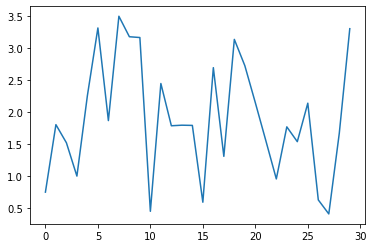

In [23]:
pos_1 = np.array([[0.4,0.4],[0.4,0.6],[0.6, 0.4], [0.6,0.6]])
vel_1 = np.array([[0.5,0.5],[1.,1.],[0.,1.01],[0.,0.]])

vel = sum([np.dot(i,i) for i in vel_1])

pos_2 = np.array([[0.4,0.4],[0.4,0.6],[0.6, 0.4], [0.6,0.6]])
# vel_2 = np.array([[0.502,0.502],[1.02,1.02],[0.02,1.02],[0.02,0.02]]) #Slight change
vel_2 = np.array([[0.5,0.5],[1.,1.0],[0.,1.],[0.,0.]])


f_pos_1, f_vel_1 = event_driven(pos_1, vel_1)
f_pos_2, f_vel_2 = event_driven(pos_2, vel_2)

dist = [] 

for i in range(len(f_vel_1)):
    diff = f_vel_1[i]-f_vel_2[i]
    dist.append(np.dot(diff,diff)) #|diff|^2
    
print(sum(dist)/vel)

def mean_distances(event_number):
    f_pos_1, f_vel_1 = event_driven(pos_1, vel_1,event_number)
    f_pos_2, f_vel_2 = event_driven(pos_2, vel_2,event_number)
    
    diff = f_vel_2 - f_vel_1
    dist = [np.dot(i,i) for i in diff]

#     dist = np.zeros(len(f_vel_1))

#     for i in range(len(f_vel_1)):
#         diff = f_vel_1[i]-f_vel_2[i]
#         dist[i] = (np.dot(diff,diff))
    
    return sum(dist)/vel

dist

event_number = list(range(0,30))
mean_dist = list(map(mean_distances, event_number))
plt.plot(event_number, mean_dist)

In [11]:
f_velocites1 = event_driven_approach(positions,velocities)
f_velocites2 = event_driven_approach(positions2,velocities2)

# print(f_velocites1)
# print()
# print(f_velocites2)

V1 = [np.sqrt(i**2 + j**2) for i,j in f_velocites1]
V1_sum = sum(np.array(V1)**2) 

V2 = [np.sqrt(i**2 + j**2) for i,j in f_velocites2]
V2_sum = sum(np.array(V2)**2)

V3 = []

for i in V1:
    for j in V2:
        V3.append((i-j)**2)
        
V3_sum = sum(V3)
        
print(V3_sum/V1_sum)

NameError: name 'positions2' is not defined

0.9651423667717529


In [52]:
def mean_distance(n_events):
    
    f_velocites1 = event_driven_approach(positions,velocities,n_events)
    f_velocites2 = event_driven_approach(positions2,velocities2,n_events)
    
    V1 = [np.sqrt(i**2 + j**2) for i,j in f_velocites1]
    V1_sum = sum(np.array(V1)**2)

    V2 = [np.sqrt(i**2 + j**2) for i,j in f_velocites2]
    v3 = []
    for i in V1:
        for j in V2:
            V3.append((i-j)**2)
        
    V3_sum = sum(V3)
    
    return V1_sum/V3_sum

In [53]:
event_number = list(range(1,1500,5))
mean_dist = list(map(mean_distance, event_number))

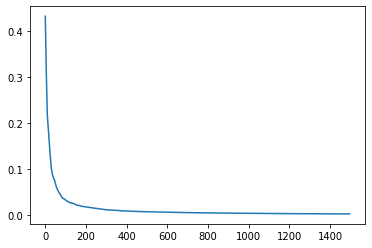

In [54]:
plt.plot(event_number, mean_dist)

In [10]:
def event_driven_approach(positions, velocities, n_events=2000):
    L = 1. ## Box edge length
    Natoms = 4  # Number of disks
    density = 0.05 # Fraction of the area of the box covered by the disks
    Ratom = np.sqrt(density/(Natoms*np.pi))   ## Radius of disk.

    ## List indexing all pairs of atoms.
    pairs = [[i,j] for i in range(Natoms) for j in range(i+1, Natoms)] 
#     print(pairs)

    t = 0.0 # Initial time.
#     n_events = 20 # Number of collision events.

    for event in range(n_events):
        # Wall collision times for all disks and their velocity components.
        wall_times = [wall_time(positions[i][j], velocities[i][j], Ratom) for i in range(Natoms) for j in range(2)]
        # Pair collision times
        pair_times = [pair_time(positions[i], velocities[i], positions[j], velocities[j], Ratom) for i,j in pairs] 
        # The next collision event is the minimum of wall and pair collision times.
        next_event = min(wall_times + pair_times)  
        t += next_event 
        for i in range(Natoms):
            positions[i] += velocities[i]*next_event # Evolve positions to collision event
#             print(positions)
        if min(wall_times) < min(pair_times): # Check if next event is a collision with a wall or pair collions
            wall_index = wall_times.index(next_event)
            particle, component = divmod(wall_index, 2) ##)How does that even work?
            velocities[particle][component] *= -1.0 ## Velocity component normal to wall changes sign
        else:
            pair_index = pair_times.index(next_event)
            particle_1, particle_2 = pairs[pair_index] # Indices of particles participating in collision.
            rel_pos = positions[particle_2] - positions[particle_1]
            rel_vel = velocities[particle_2] - velocities[particle_1]
            distance = np.sqrt(np.dot(rel_pos,rel_pos))
            unit_perp = rel_pos/distance
            scal_prod = np.dot(rel_vel,unit_perp)
            velocities[particle_1] += scal_prod*unit_perp # Change in velocities of atoms colliding with each other
            velocities[particle_2] -= scal_prod*unit_perp
            
    return positions,velocities

In [66]:
positions = np.array([[0.4,0.4],[0.4,0.6],[0.6, 0.4], [0.6,0.6]])
velocities = np.array([[0.5,0.5],[1.,1.],[0.,1.],[0.,0.]])

positions1 ,velocities1 = event_driven_approach(positions, velocities)

print(positions1, velocities1)

velocities3 = np.zeros((len(velocities1),2))
print(velocities)
# position2, velocities2 = event_driven_approach(positions1, velocities3)

[[0.2280605  0.09055611]
 [0.36318432 0.75220491]
 [0.30689639 0.93692169]
 [0.75295032 0.31978045]] [[-0.33637915 -0.02376902]
 [-0.49325164  0.90941835]
 [-0.47117985 -0.89069819]
 [-0.15369269  1.13003098]]
[[-0.33637915 -0.02376902]
 [-0.49325164  0.90941835]
 [-0.47117985 -0.89069819]
 [-0.15369269  1.13003098]]


C:\Users\shyam\AppData\Local\Temp/ipykernel_14268/3575980666.py:23: RuntimeWarning: invalid value encountered in multiply
  positions[i] += velocities[i]*next_event # Evolve positions to collision event


In [39]:
print(position2, velocities2)

[[0.47692849 0.2204531 ]
 [0.59641991 0.80816249]
 [0.59374626 0.17281798]
 [0.7236338  0.43623098]] [[-1.24683277  0.18875069]
 [ 0.39650021  0.34971754]
 [-0.87521565 -0.01496807]
 [ 0.82206166  0.43388319]]


In [37]:
x = [1,2,3,4]
-1*np.array(pairs)

array([[ 0, -1],
       [ 0, -2],
       [ 0, -3],
       [-1, -2],
       [-1, -3],
       [-2, -3]])

In [47]:
def area(a, b=2): 
    return a*b

In [49]:
area(4,7)

28

In [130]:
print("Hello WOrld")

Hello WOrld
